In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, feats, strategies
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strategies)

<module 'libs.strategies' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strategies.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import json
import re
import os
import psutil

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [3]:
# Read sign timestamps ( since selected year, with pre-market included)
df_inds = pd.read_csv(params.inds_unsc_csv, index_col=0, parse_dates=True)
# compute synthetic ask/bid from close_raw and configured spread
df_inds['ask'] = df_inds['close'] * (1 + params.bidask_spread_pct/100)
df_inds['bid'] = df_inds['close'] * (1 - params.bidask_spread_pct/100)

df_inds.head()

open      high       low     close   volume  \
2009-01-02 11:02:00  3.069643  3.069643  3.069643  3.069643  13160.0   
2009-01-02 11:03:00  3.069643  3.069643  3.069643  3.069643  13160.0   
2009-01-02 11:04:00  3.069643  3.069643  3.069643  3.069643  13160.0   
2009-01-02 11:05:00  3.069643  3.069643  3.069643  3.069643  13160.0   
2009-01-02 11:06:00  3.069643  3.069643  3.069643  3.069643  13160.0   

                           signal  ret  log_ret     sma_9    sma_21  \
2009-01-02 11:02:00  2.712386e-12  0.0      0.0  3.069643  3.069643   
2009-01-02 11:03:00  3.073542e-12  0.0      0.0  3.069643  3.069643   
2009-01-02 11:04:00  3.482881e-12  0.0      0.0  3.069643  3.069643   
2009-01-02 11:05:00  3.946510e-12  0.0      0.0  3.069643  3.069643   
2009-01-02 11:06:00  4.472090e-12  0.0      0.0  3.069643  3.069643   

                     sma_pct_9  sma_pct_21     ema_9    ema_21  roc_9  roc_21  \
2009-01-02 11:02:00        0.0         0.0  3.069643  3.069643    0.0     0.0   
2009-01-02 11:03:00        0.0         0.0  3.069643  3.069643    0.0     0.0   
2009-01-02 11:04:00        0.0         0.0  3.069643  3.069643    0.0     0.0   
2009-01-02 11:05:00        0.0         0.0  3.069643  3.069643    0.0     0.0   
2009-01-02 11:06:00        0.0         0.0  3.069643  3.069643    0.0     0.0   

                     body  body_pct  upper_shad  lower_shad  range_pct    rsi  \
2009-01-02 11:02:00   0.0       0.0         0.0         0.0        0.0  100.0   
2009-01-02 11:03:00   0.0       0.0         0.0         0.0        0.0  100.0   
2009-01-02 11:04:00   0.0       0.0         0.0         0.0        0.0  100.0   
2009-01-02 11:05:00   0.0       0.0         0.0         0.0        0.0  100.0   
2009-01-02 11:06:00   0.0       0.0         0.0         0.0        0.0  100.0   

                     macd_line  macd_signal  macd_diff  atr  atr_pct  \
2009-01-02 11:02:00        0.0          0.0        0.0  0.0      0.0   
2009-01-02 11:03:00        0.0          0.0        0.0  0.0      0.0   
2009-01-02 11:04:00        0.0          0.0        0.0  0.0      0.0   
2009-01-02 11:05:00        0.0          0.0        0.0  0.0      0.0   
2009-01-02 11:06:00        0.0          0.0        0.0  0.0      0.0   

                     bb_lband  bb_hband  bb_w  plus_di  minus_di  adx  \
2009-01-02 11:02:00  3.069643  3.069643   0.0      0.0       0.0  0.0   
2009-01-02 11:03:00  3.069643  3.069643   0.0      0.0       0.0  0.0   
2009-01-02 11:04:00  3.069643  3.069643   0.0      0.0       0.0  0.0   
2009-01-02 11:05:00  3.069643  3.069643   0.0      0.0       0.0  0.0   
2009-01-02 11:06:00  3.069643  3.069643   0.0      0.0       0.0  0.0   

                           obv      vwap  vwap_dev_pct  vol_spike  vol_z_14  \
2009-01-02 11:02:00  1618680.0  3.069643 -1.446713e-14        1.0       0.0   
2009-01-02 11:03:00  1631840.0  3.069643 -1.446713e-14        1.0       0.0   
2009-01-02 11:04:00  1645000.0  3.069643 -1.446713e-14        1.0       0.0   
2009-01-02 11:05:00  1658160.0  3.069643 -1.446713e-14        1.0       0.0   
2009-01-02 11:06:00  1671320.0  3.069643 -1.446713e-14        1.0       0.0   

                     rolling_max_close_21  rolling_min_close_21  dist_high_21  \
2009-01-02 11:02:00              3.069643              3.069643           0.0   
2009-01-02 11:03:00              3.069643              3.069643           0.0   
2009-01-02 11:04:00              3.069643              3.069643           0.0   
2009-01-02 11:05:00              3.069643              3.069643           0.0   
2009-01-02 11:06:00              3.069643              3.069643           0.0   

                     dist_low_21    obv_sma  obv_diff_14    obv_pct_14  \
2009-01-02 11:02:00          0.0  1533140.0     184240.0  60020.011635   
2009-01-02 11:03:00          0.0  1546300.0     184240.0  60020.011635   
2009-01-02 11:04:00          0.0  1559460.0     184240.0  60020.011635   
2009-01-02 11:05:00          0.0  1572620.0     184240.0  600

In [5]:
importlib.reload(strategies) ######
importlib.reload(params) ######

sim_results = {}
groups = df_inds.groupby(df_inds.index.normalize())
total_days = df_inds.index.normalize().nunique()

for day, df_day in tqdm(groups, desc="Smoothing+Generate+Simulate", total=total_days):
    
    # actions generator now also produces a trail computed from resulting actions
    df_actions = strategies.generate_tradact_inds(
        df              = df_day,
        col_signal      = "ema_9",
        sign_thresh     = "ema_21",
        sellmin_idx     = params.sellmin_idx_tick,
        trailstop_pct   = params.trailstop_pct_tick,
        sess_start      = params.sess_start_tick
    )

    # simulator consumes df_actions (expects trailstop_price present)
    sim_results.update(
        strategies.simulate_trading(
            day         = day,
            df          = df_actions,
            sellmin_idx = params.sellmin_idx_tick,
            sess_start  = params.sess_start_tick
        )
    )


Smoothing+Generate+Simulate:   0%|          | 0/4141 [00:00<?, ?it/s]

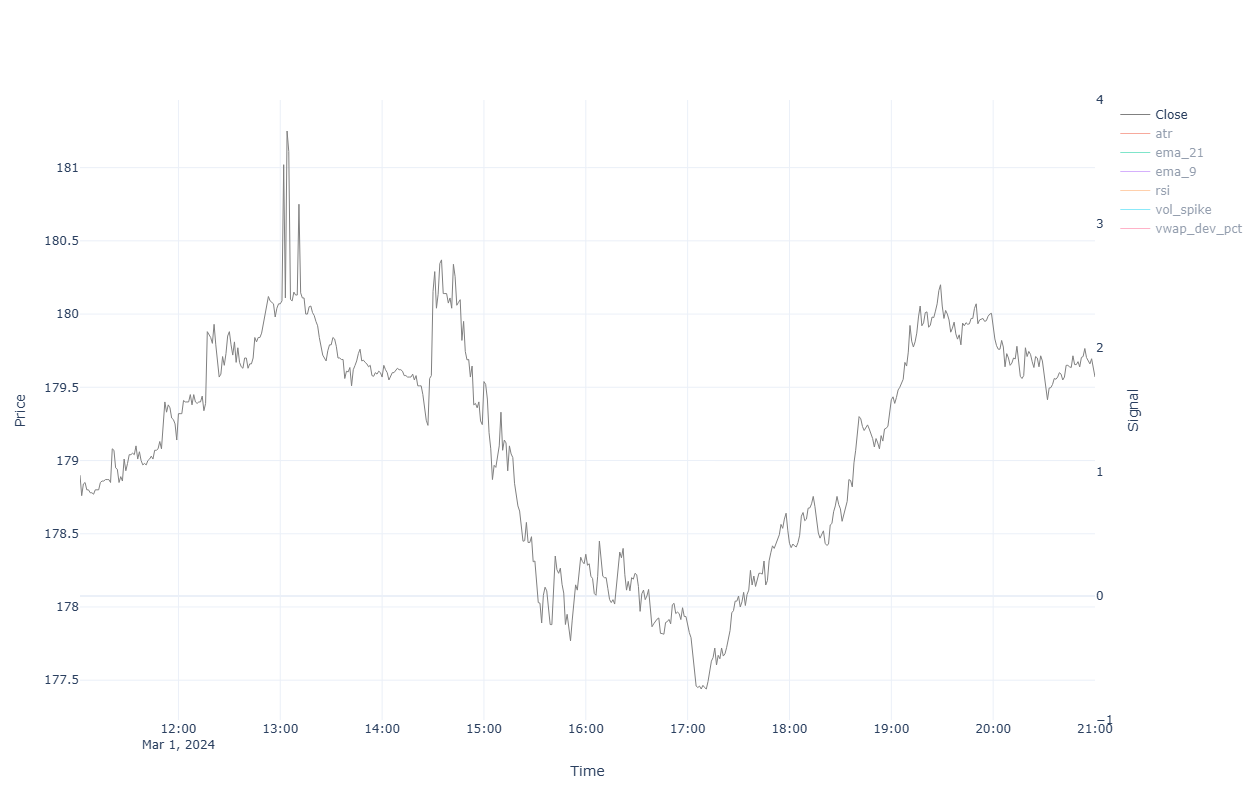

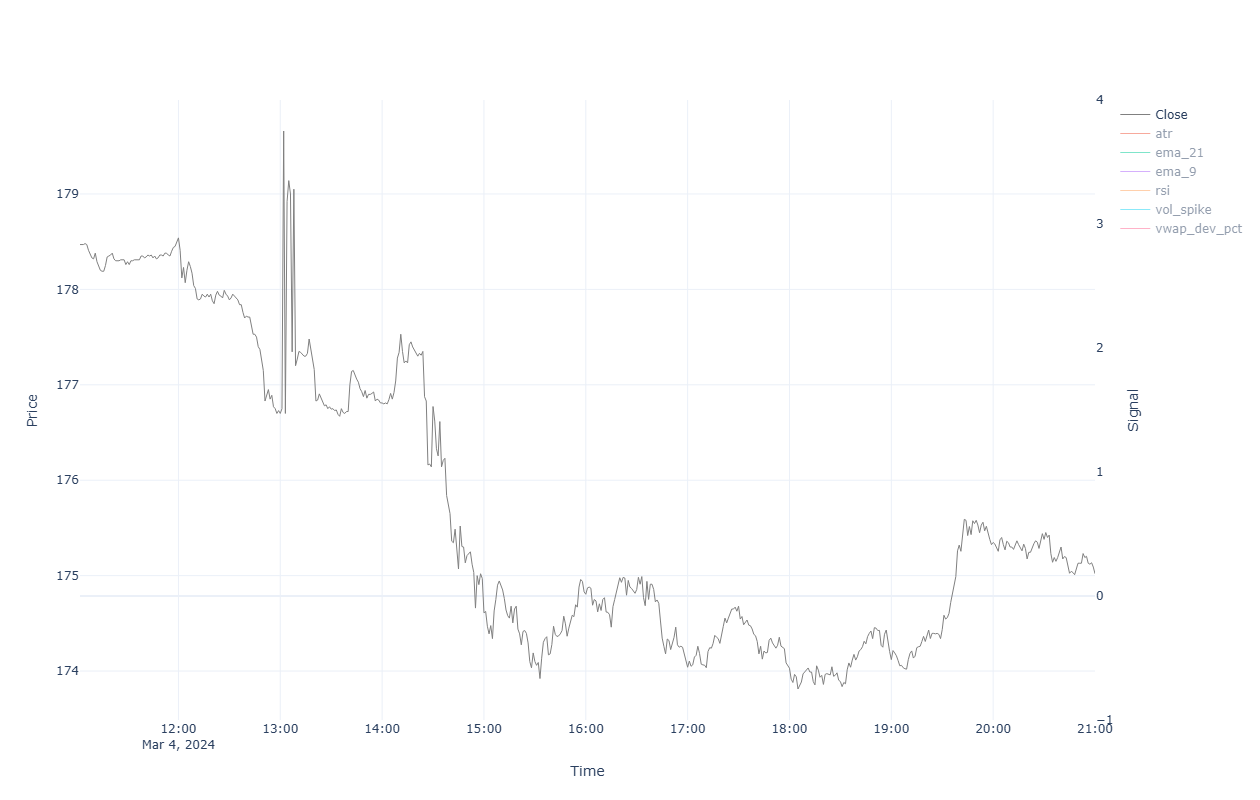

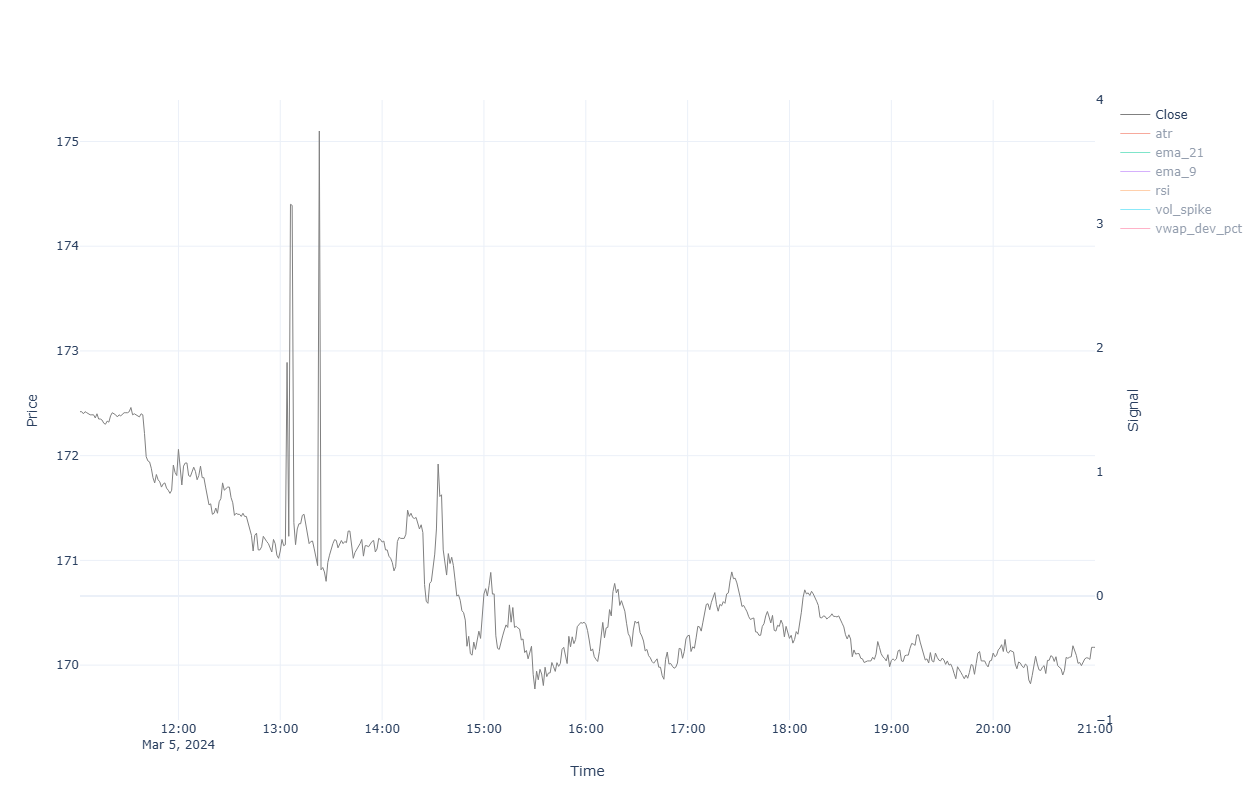

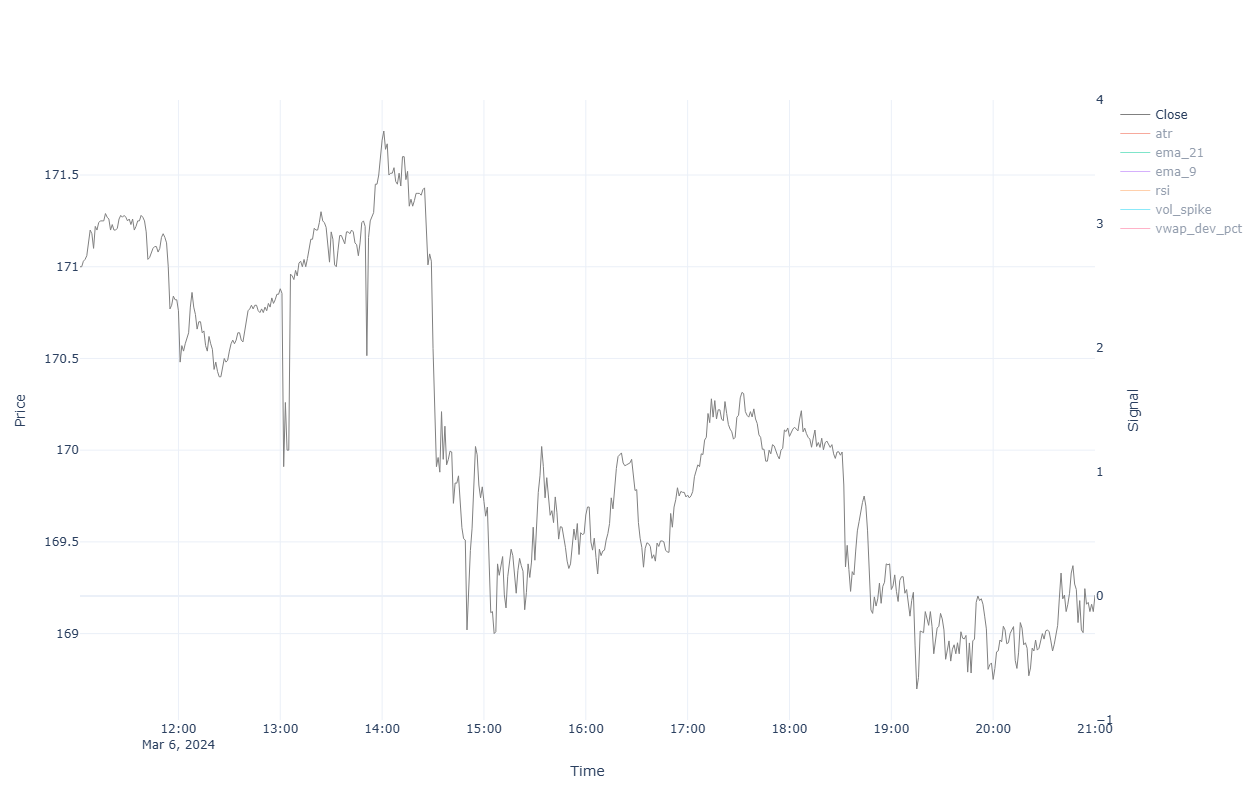

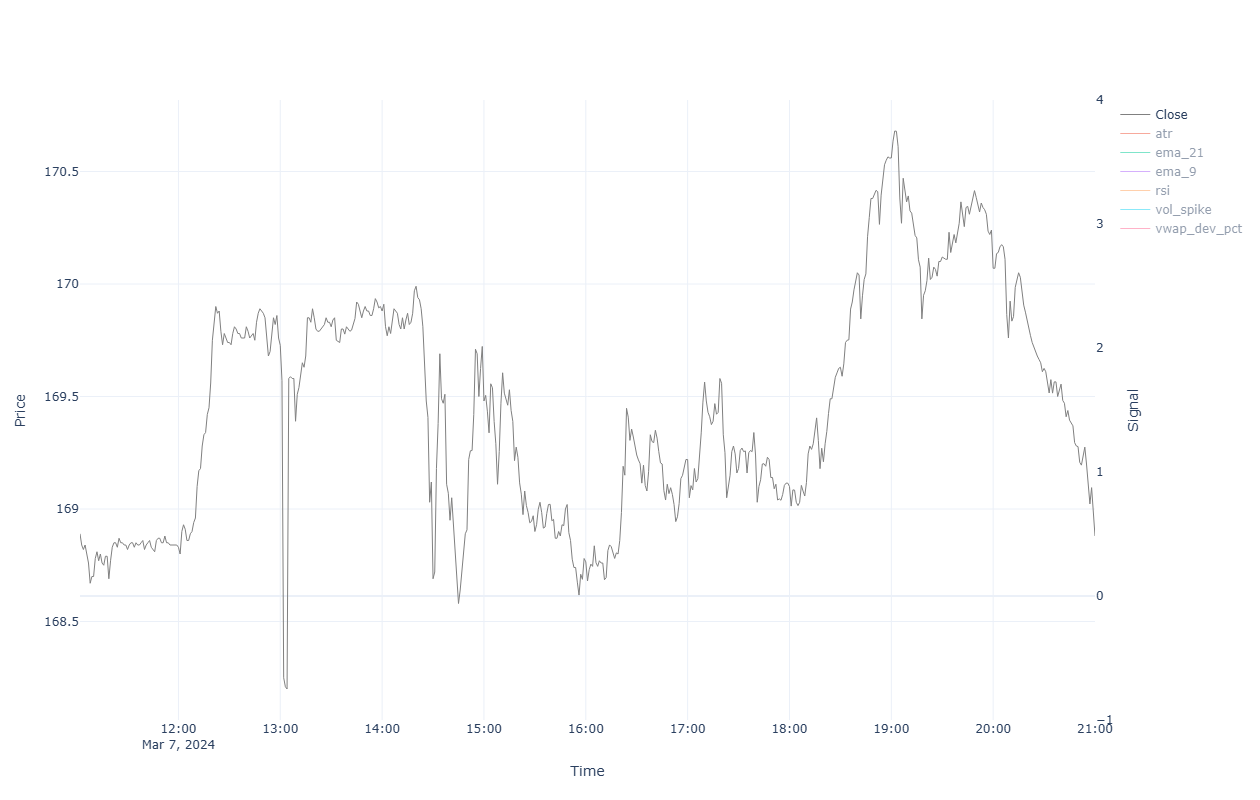

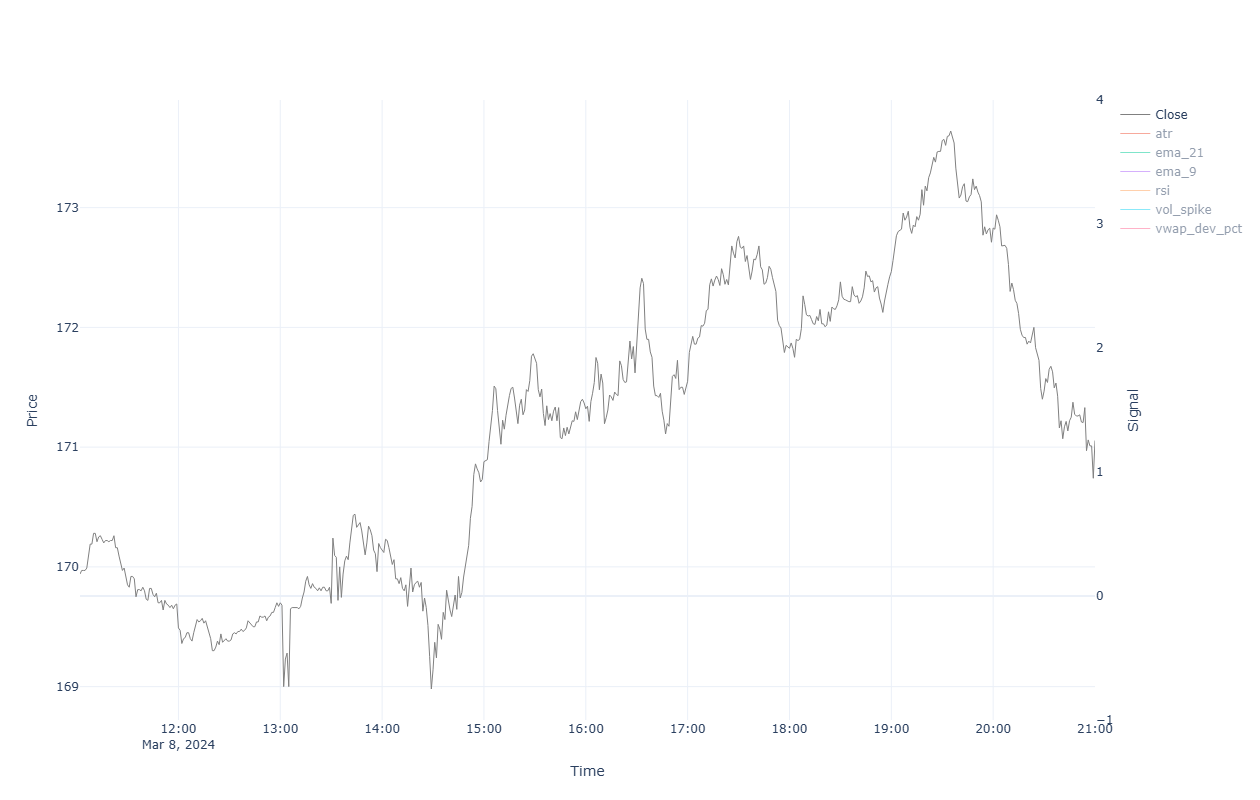

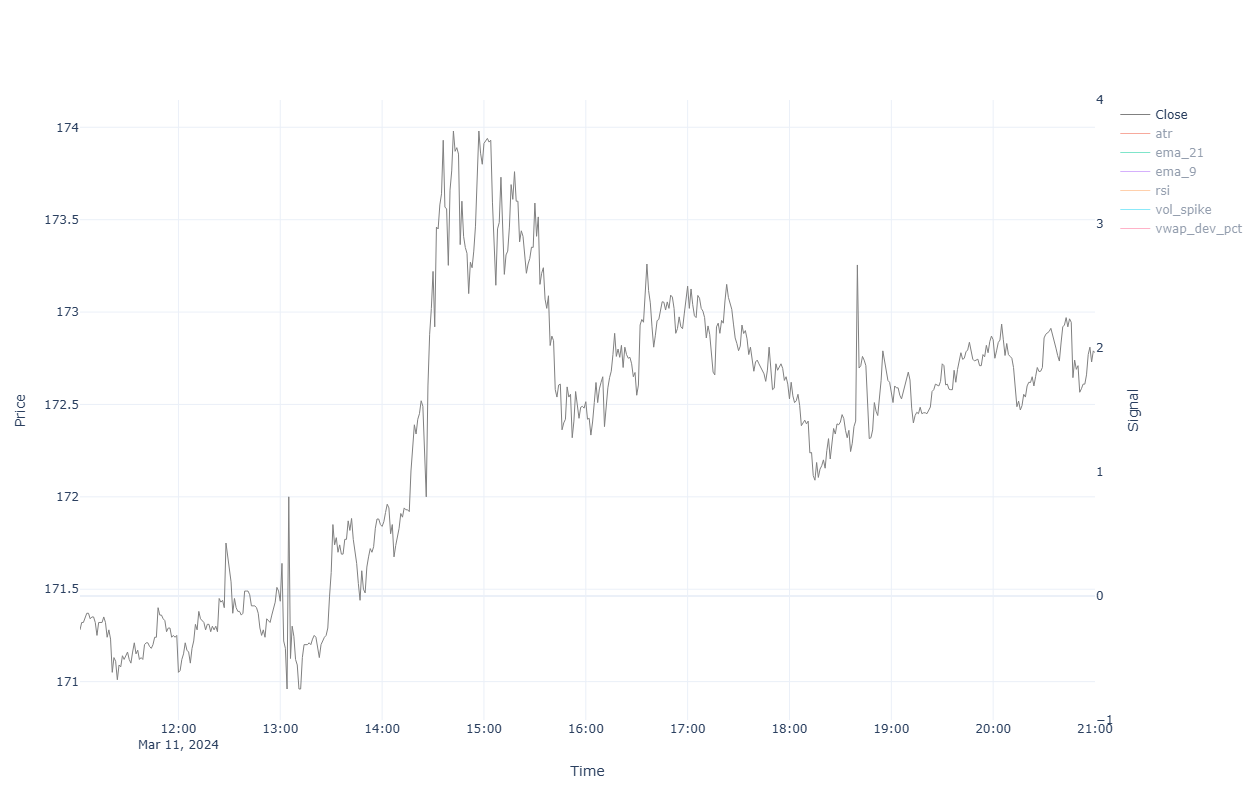

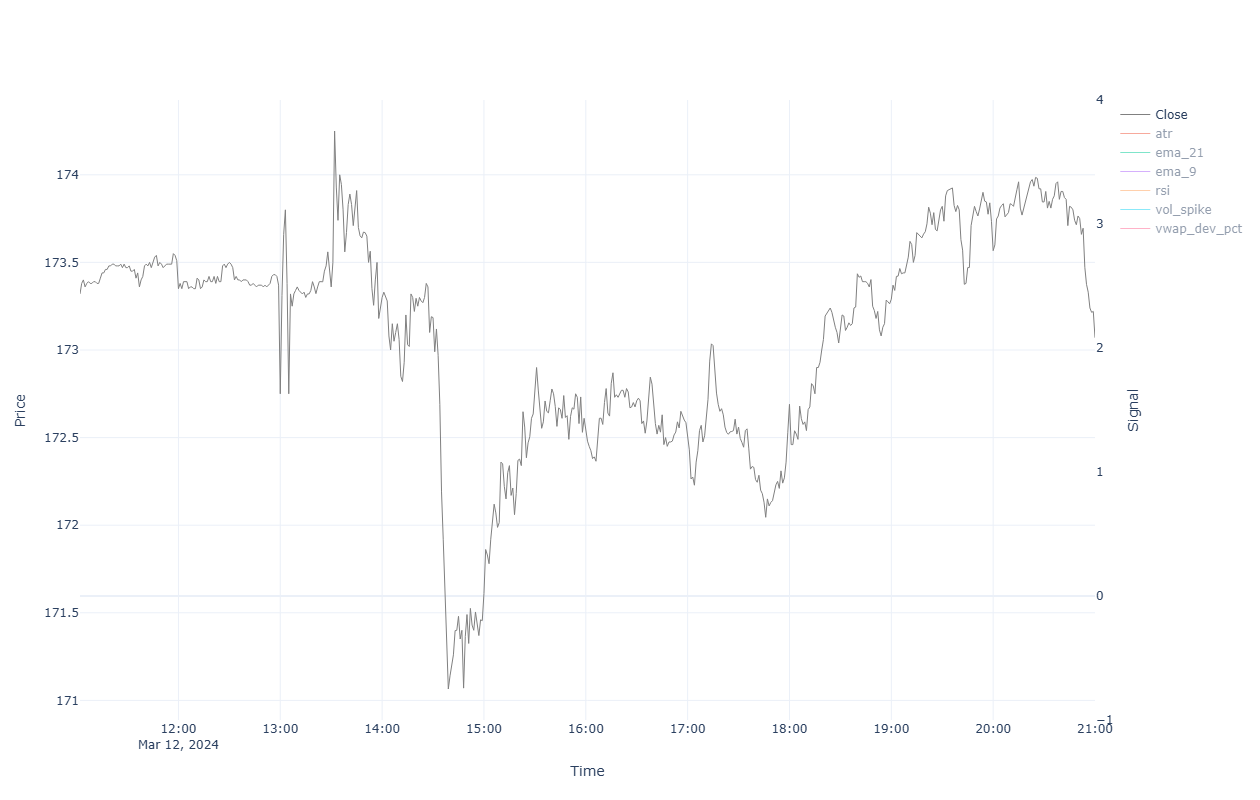

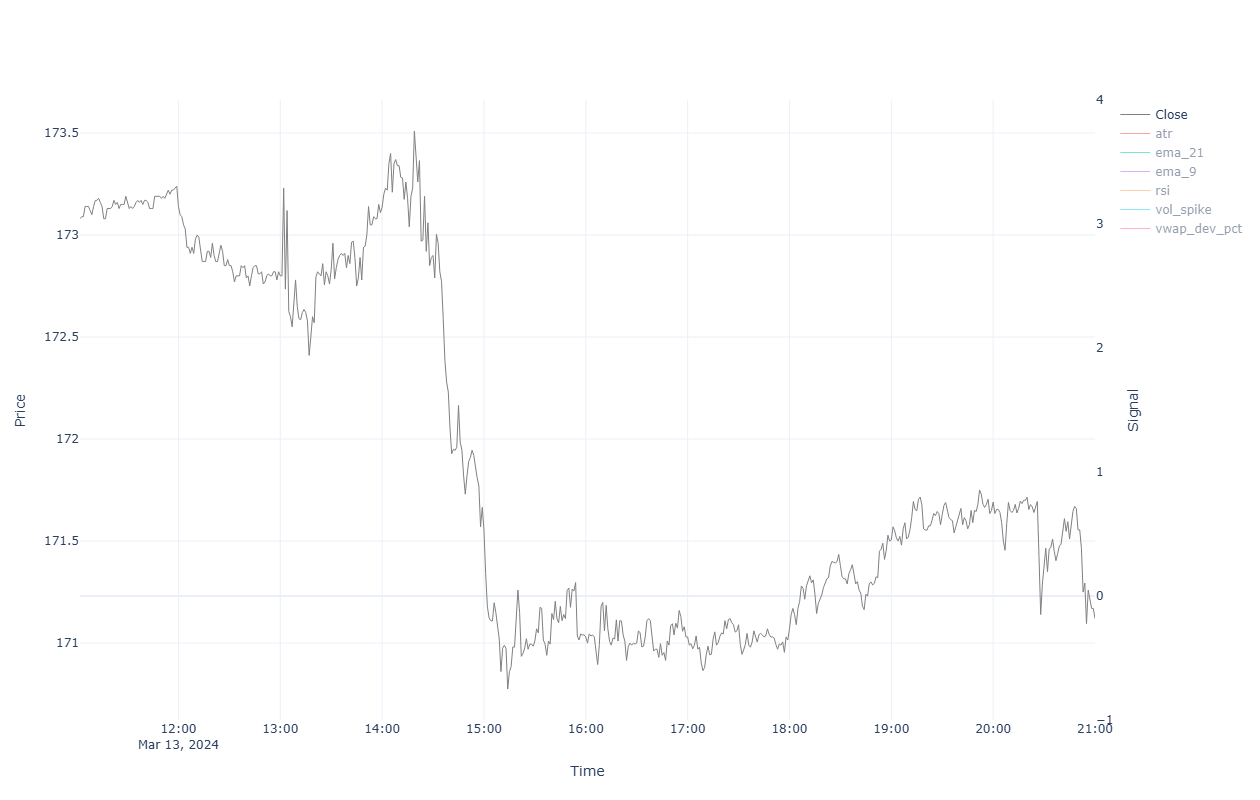

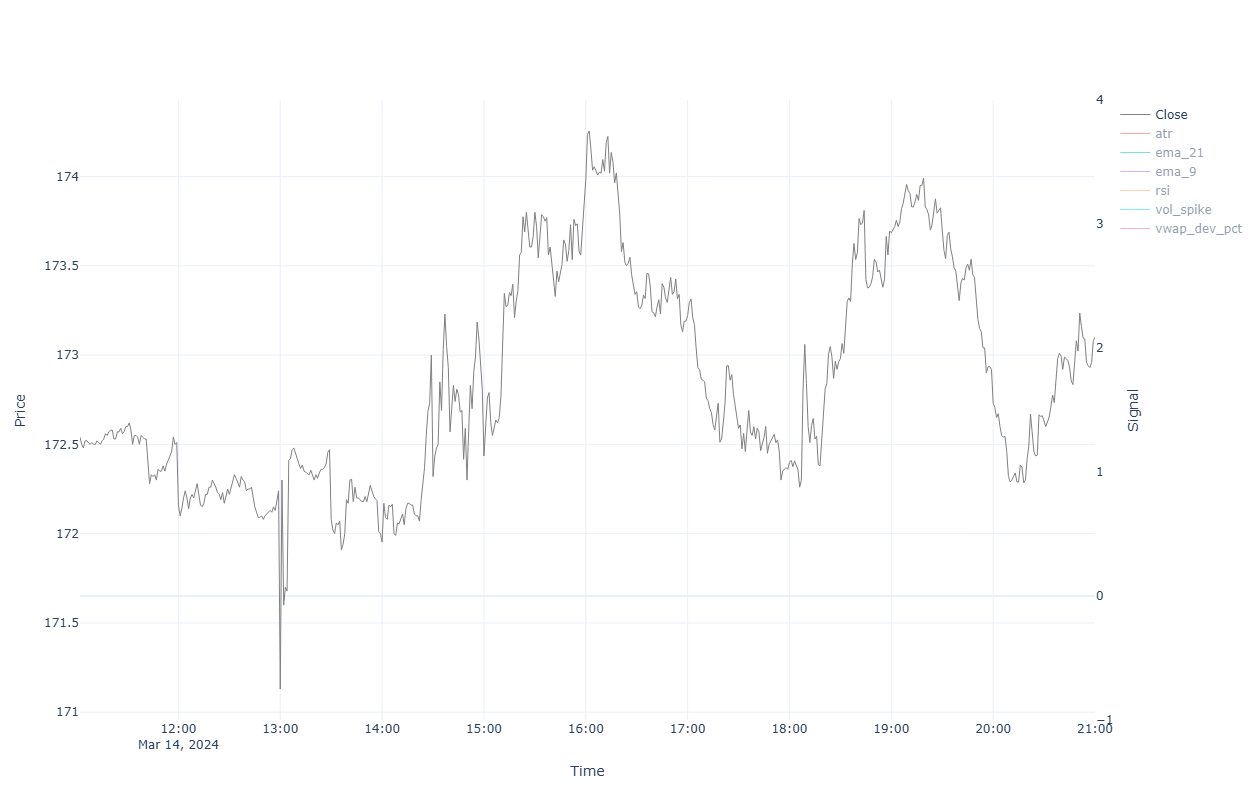

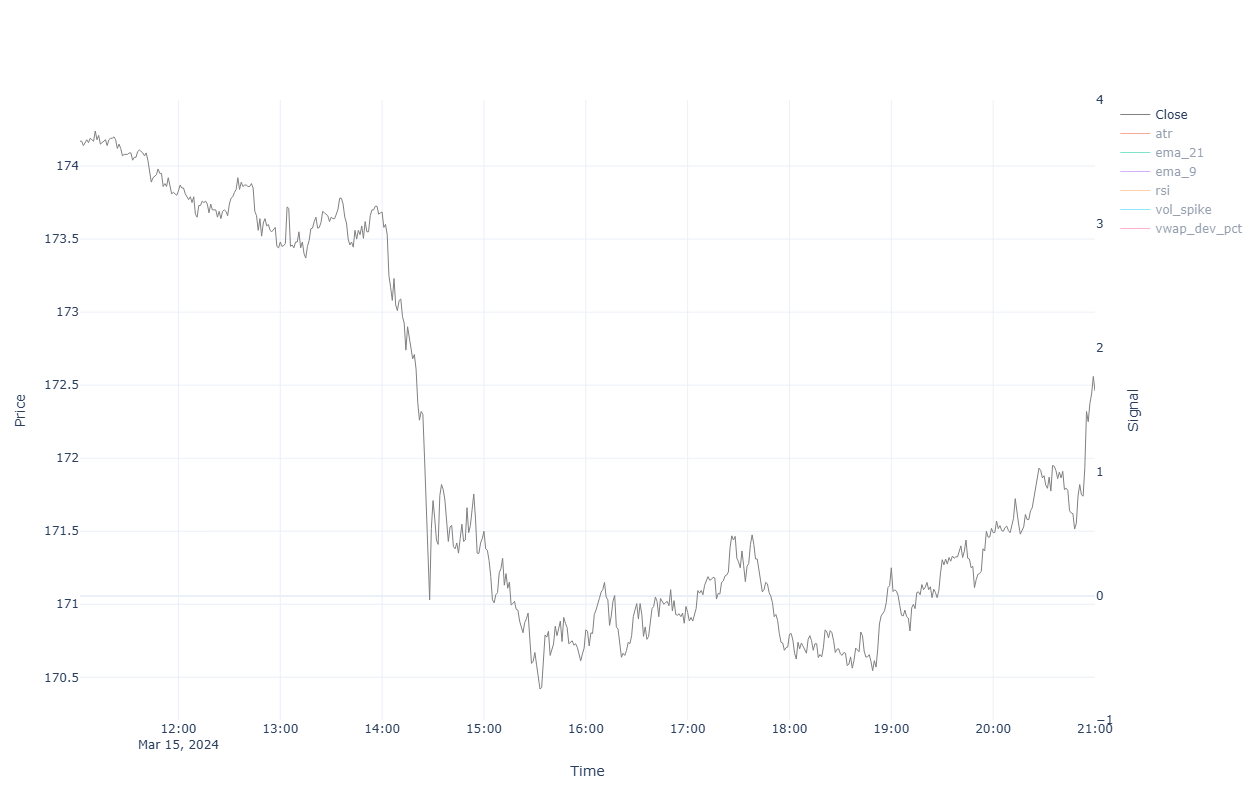

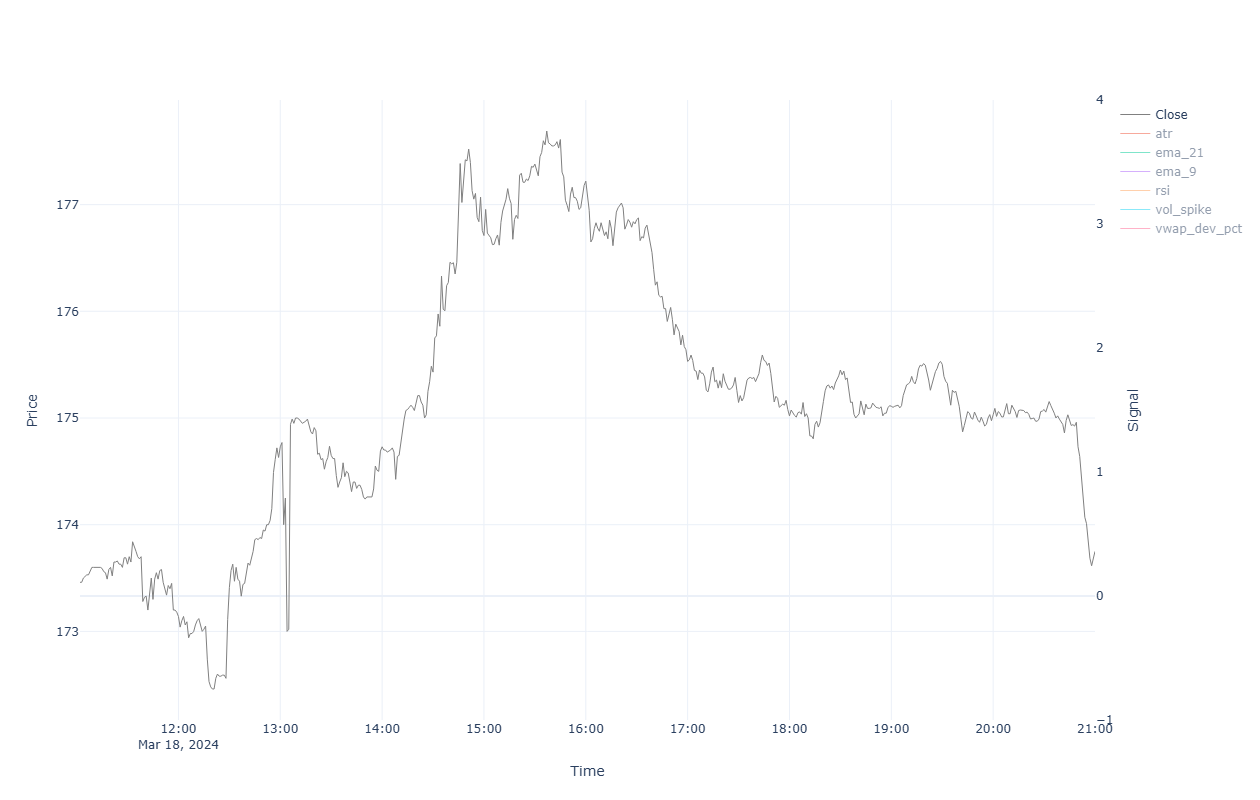

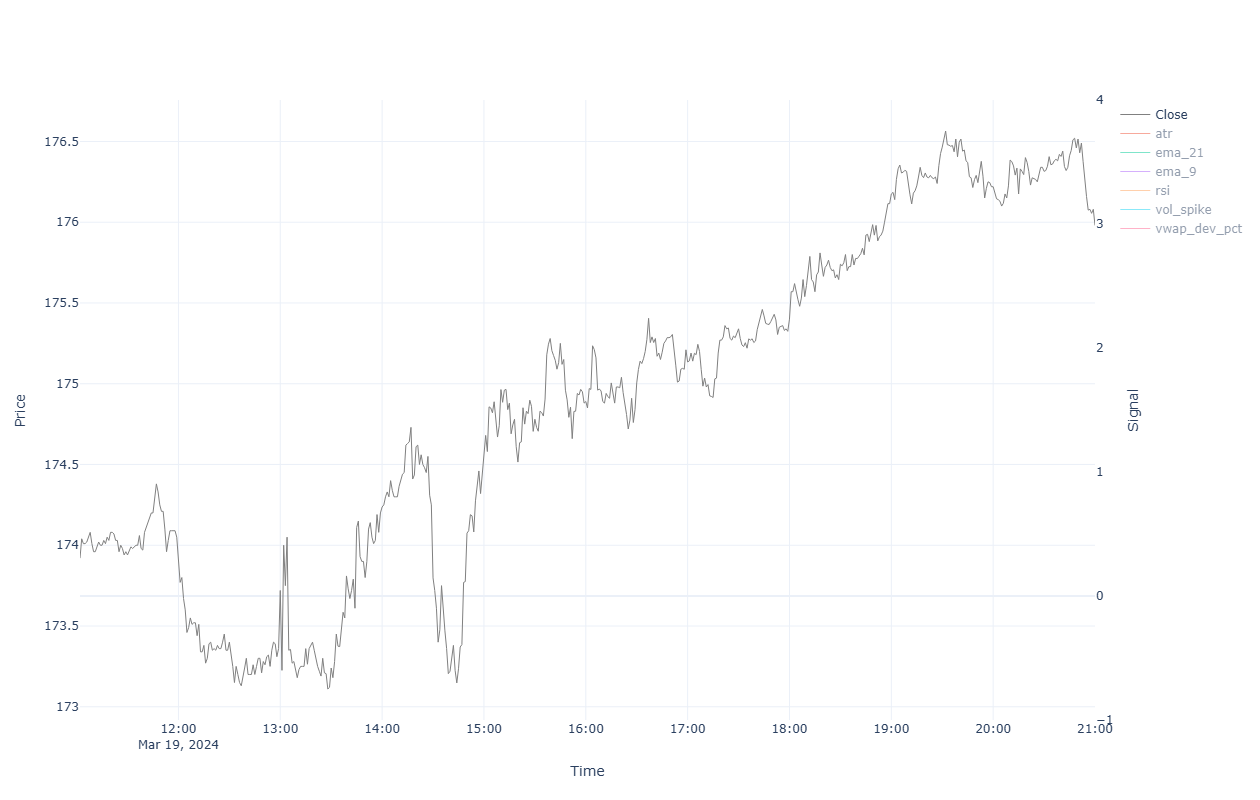

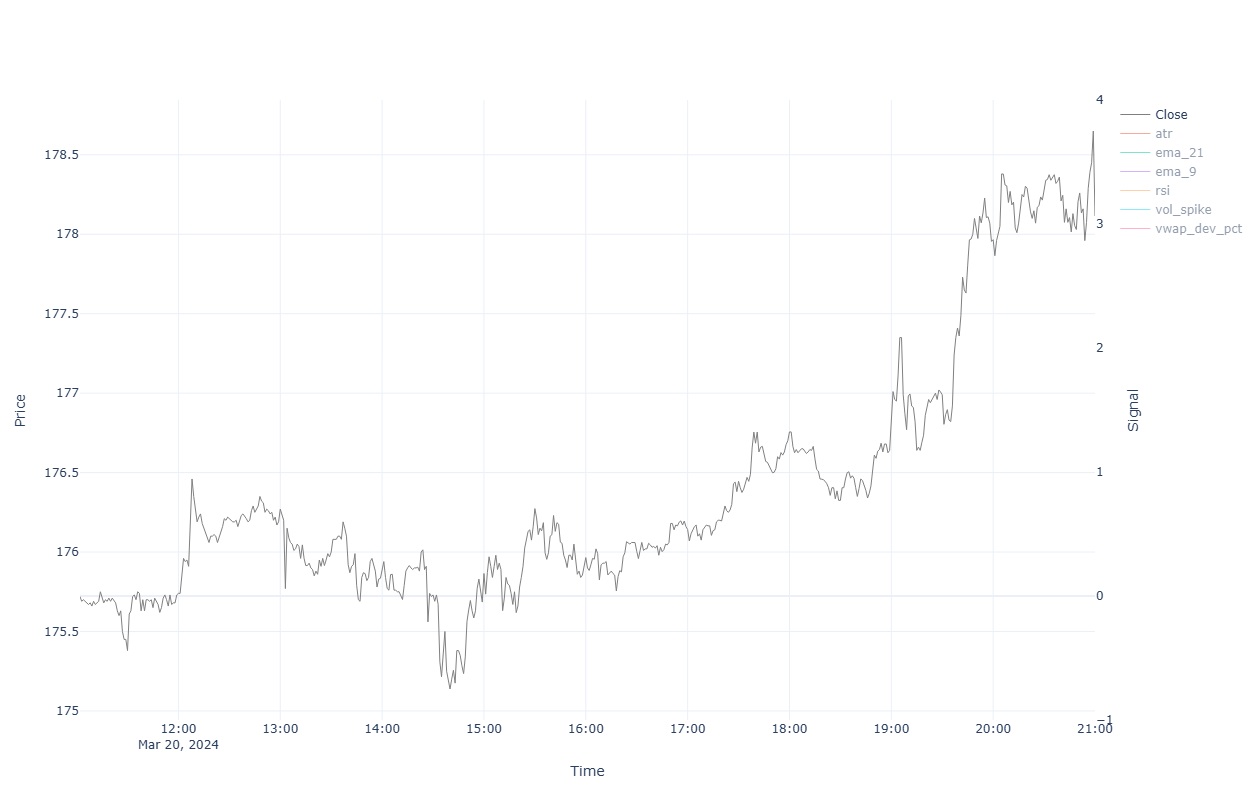

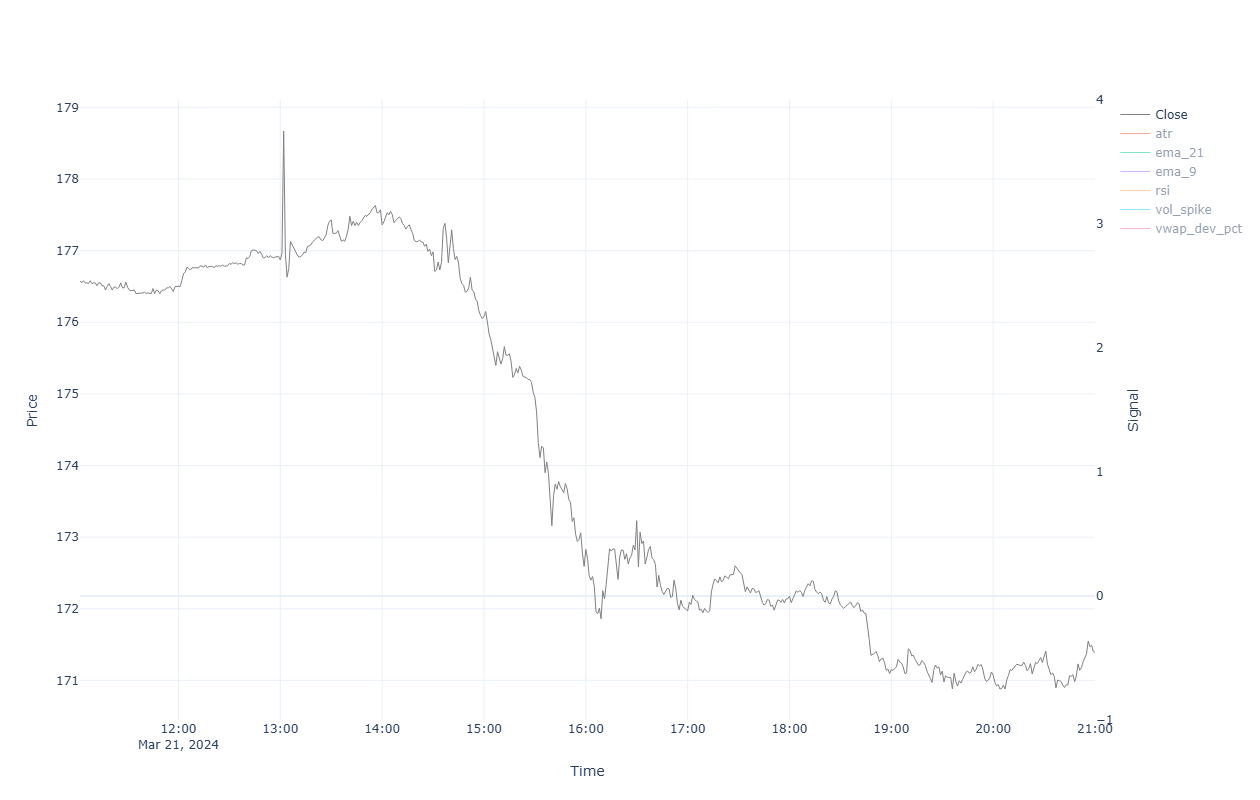

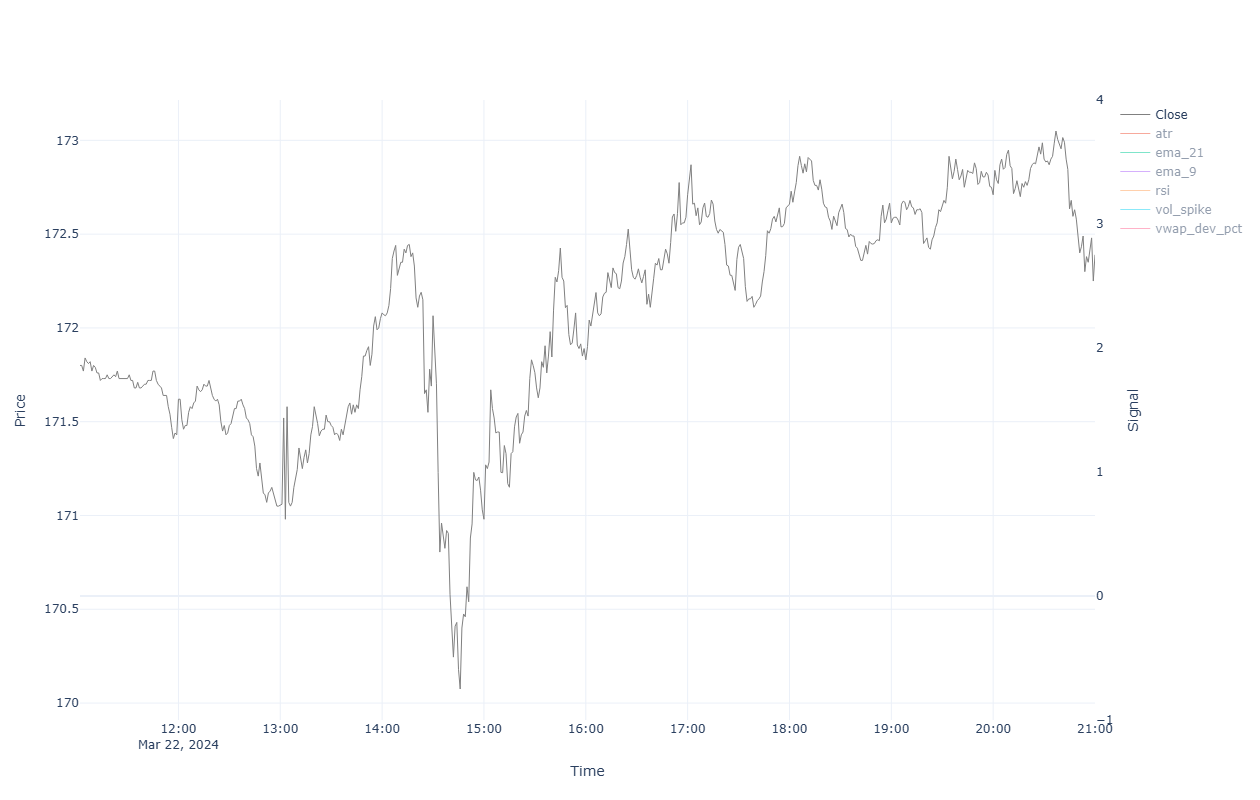

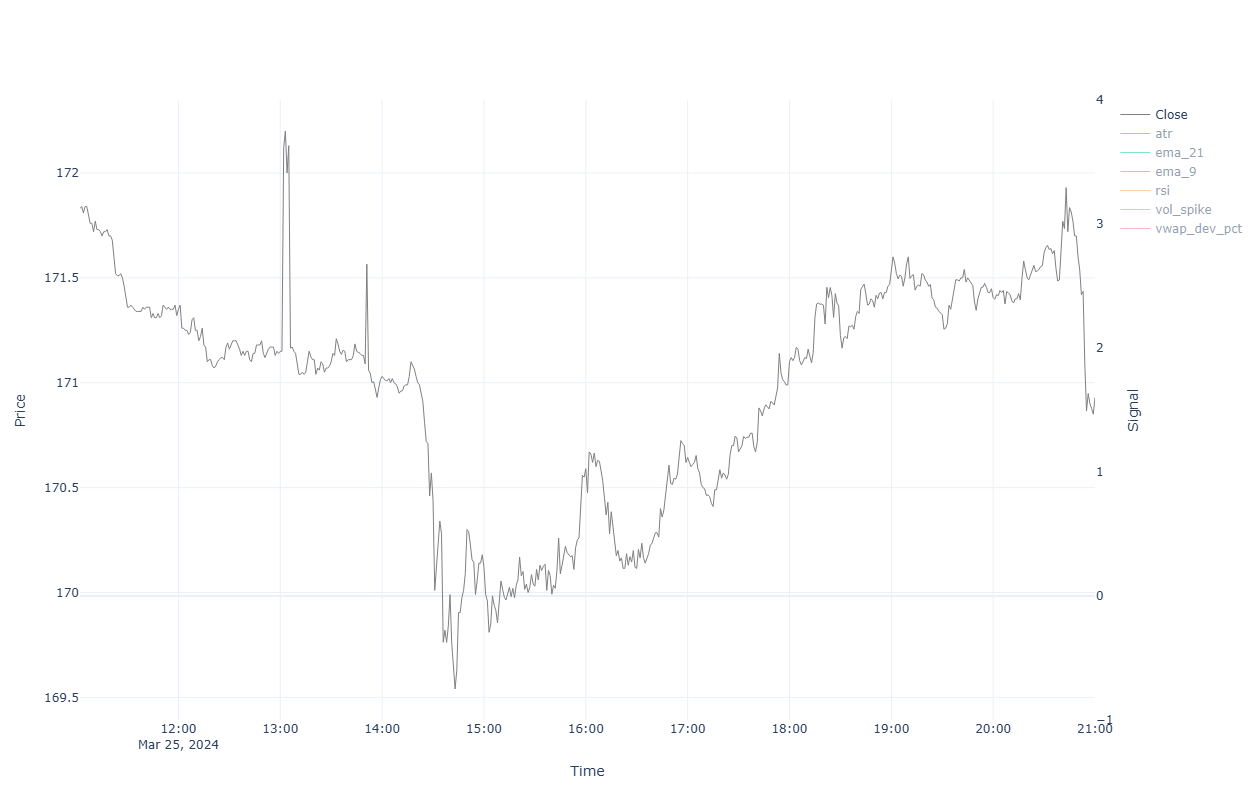

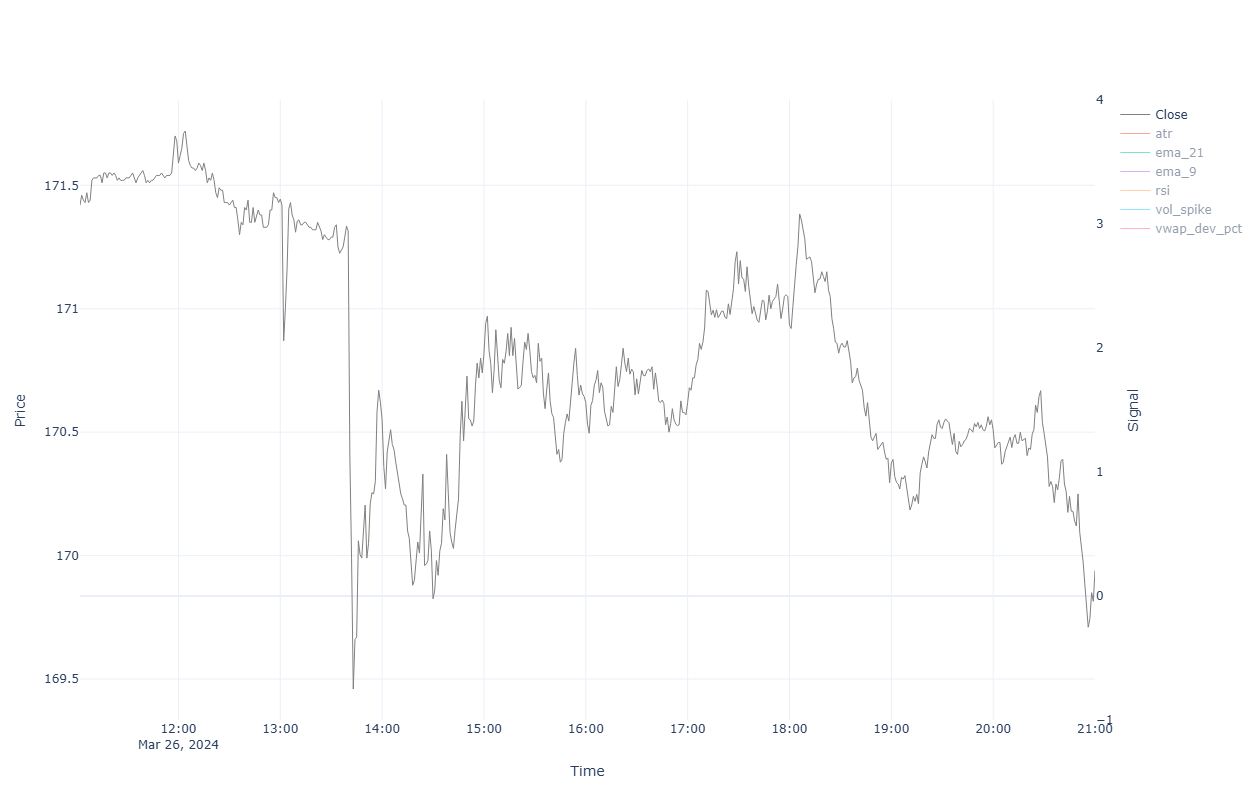

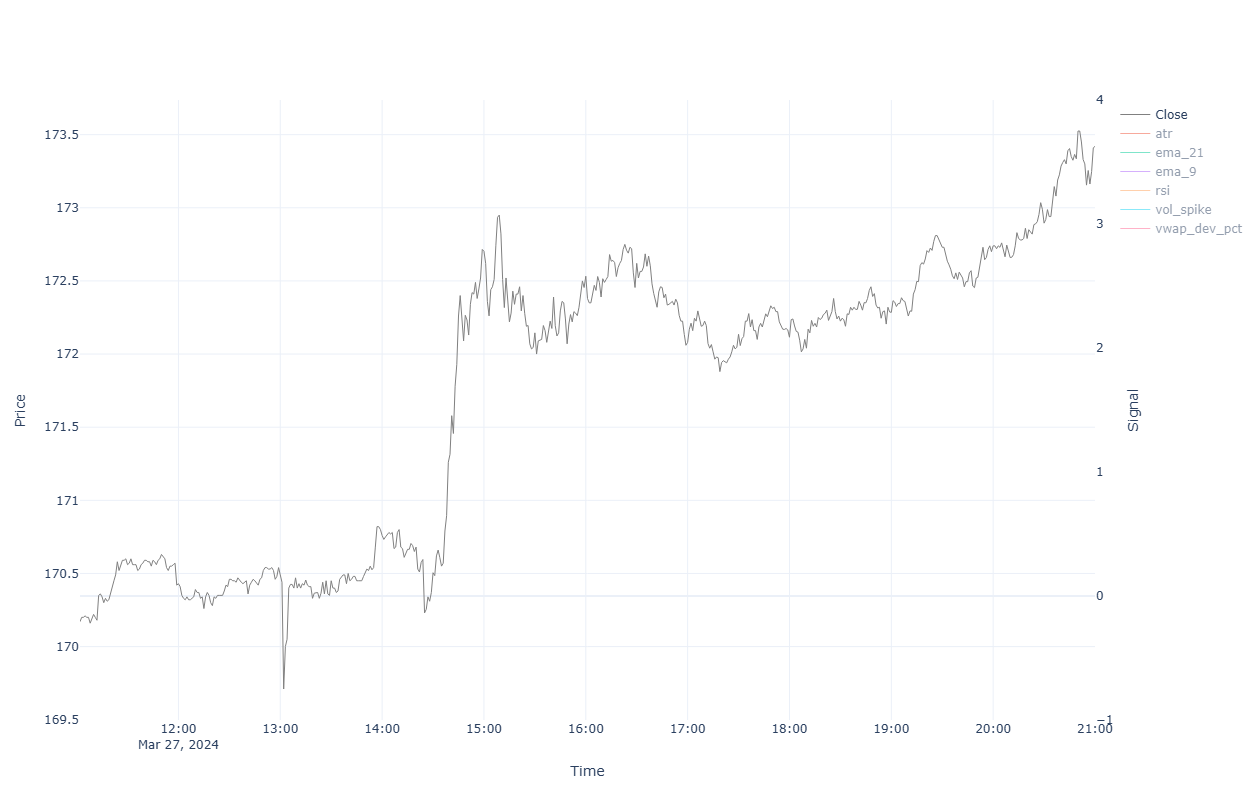

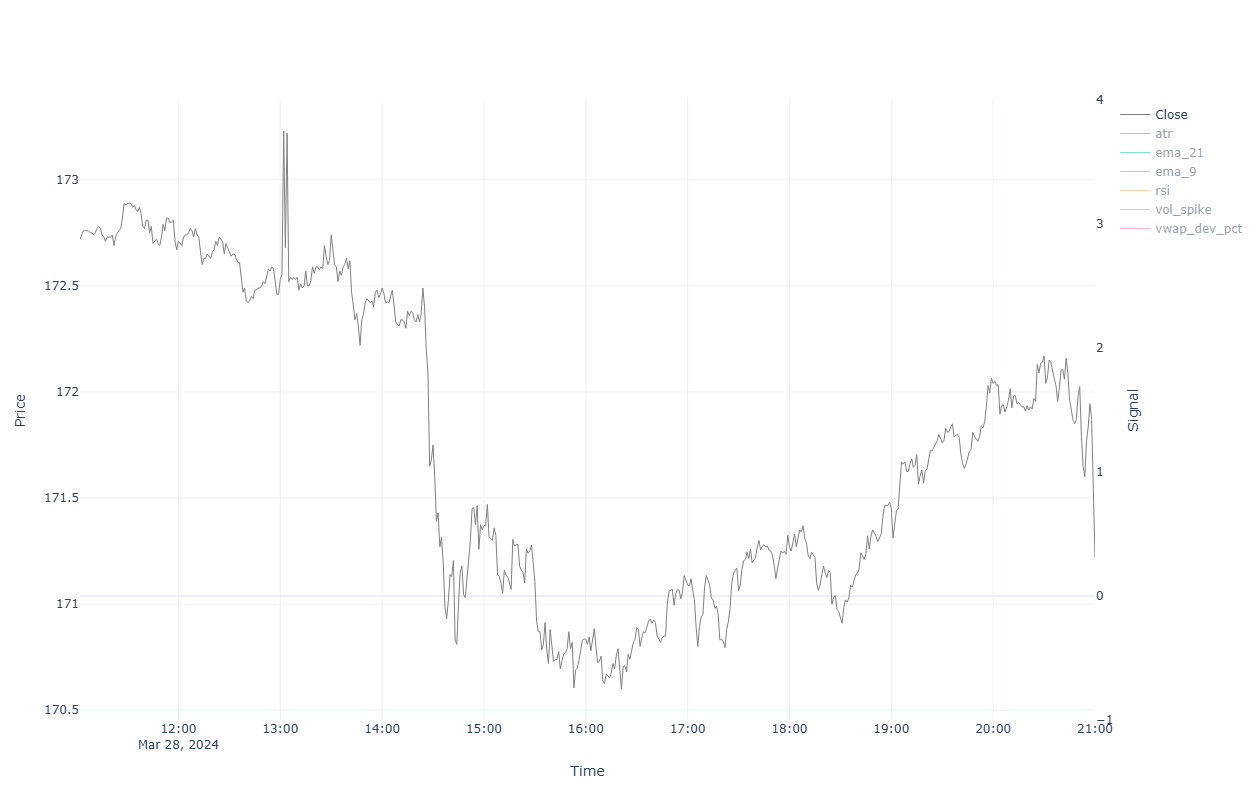

In [6]:
importlib.reload(plots)
feats_inds = ['ema_9','ema_21','rsi','vwap_dev_pct','vol_spike','atr']

df_month = df_inds[df_inds.index.to_period('M') == params.month_to_check].copy()

for day in df_month.index.normalize().unique():
    # select all timestamps on this day
    df_day = df_month[df_month.index.normalize() == day]
    if df_day.empty:
        continue
    plots.plot_trades(
        df        = df_day,
        features  = feats_inds,
        autoscale = False)  